In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [163]:
image_path_train = "marble/train/good"
image_path_ok = "marble/test/good"

In [164]:
BATCH_SIZE = 16
N_EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {DEVICE}.")

The device is cpu.


In [165]:
import math


class ConvAutoencoder(nn.Module):
    def __init__(self, input_size=128, img_channels=3, feature_dim=256):
        super(ConvAutoencoder, self).__init__()

        assert math.log2(input_size).is_integer(), "Input size must be a power of 2 (e.g., 64, 128, 256)"
        self.input_size = input_size

        # Build encoder dynamically
        layers = []
        channels = [img_channels, 16, 32, 64, 128]
        size = input_size
        for i in range(len(channels) - 1):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=4, stride=2, padding=1))
            layers.append(nn.ReLU(True))
            size //= 2  # downsampling step

        self.encoder_conv = nn.Sequential(*layers)
        self.flattened_size = channels[-1] * size * size
        self.encoder_fc = nn.Linear(self.flattened_size, feature_dim)

        # Decoder
        self.decoder_fc = nn.Linear(feature_dim, self.flattened_size)

        # Build decoder (inverse of encoder)
        decoder_layers = []
        channels = list(reversed(channels))
        for i in range(len(channels) - 1):
            decoder_layers.append(nn.ConvTranspose2d(
                channels[i], channels[i+1], kernel_size=4, stride=2, padding=1))
            if i < len(channels) - 2:
                decoder_layers.append(nn.ReLU(True))
            else:
                decoder_layers.append(nn.Tanh())  # final layer

        self.decoder_conv = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        z = self.encoder_fc(x)

        x = self.decoder_fc(z)
        x = x.view(x.size(0), -1, self.input_size // (2 ** 4), self.input_size // (2 ** 4))  # 4 conv layers
        x = self.decoder_conv(x)
        return x


In [166]:
IMAGE_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [167]:
class MarbleImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, val=False):
        self.img_dir = img_dir
        self.image_names = os.listdir(self.img_dir)
        val_len = int(len(self.image_names) * 0.2)
        if val:
            # last 20% are validation images
            self.image_names = self.image_names[-val_len:]
        else:
            # everything before last 20% are training images
            self.image_names = self.image_names[:-val_len]
            
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [168]:
train_dataset = MarbleImageDataset(image_path_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [169]:
val_dataset = MarbleImageDataset(image_path_train, transform=transform, val=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [170]:
import json
from tqdm import tqdm

# model = Autoencoder().to(DEVICE)
model = ConvAutoencoder(input_size=IMAGE_SIZE).to(DEVICE)
criterion = nn.MSELoss()
if (
    os.path.exists("model.pth")
    and os.path.exists("losses.json")
    and os.path.exists("batch_losses.json")
):
    model.load_state_dict(torch.load("model.pth", weights_only=True))
    losses = json.load(open("losses.json", encoding="utf-8"))
    batch_losses = json.load(open("batch_losses.json", encoding="utf-8"))
# if False:
#     pass
else:
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    losses = []
    batch_losses = []

    for epoch in range(N_EPOCHS):
        model.train()
        total_loss = 0
        for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}"):
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_losses.append(loss.item())

        mean_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Loss: {mean_loss:.6f}")
        losses.append(mean_loss)

    json.dump(losses, open("losses.json", "w", encoding="utf-8"))
    json.dump(batch_losses, open("batch_losses.json", "w", encoding="utf-8"))

In [171]:
losses_extended = []
for loss in losses:
    for _ in range(43):
        losses_extended.append(loss)
len(losses_extended)

430

In [172]:
len(batch_losses)

430

In [173]:
import pandas as pd
import plotly.express as px

df_losses = pd.DataFrame({"Batch Loss": batch_losses})
df_losses

,Batch Loss
0,0.213674
1,0.216852
2,0.154607
3,0.136302
4,0.100273
...,...
425,0.003371
426,0.002229
427,0.002056
428,0.001426


In [174]:
fig = px.line(df_losses, title="Batch loss", labels={"value": "MSE Loss", "index": "Batch Number"})
fig.update_layout(
    width=600,
    height=300,
    margin=dict(l=20, r=20, t=40, b=20),
    showlegend=False,
)
fig.write_image("../images/batch_loss.pdf")
fig.show()

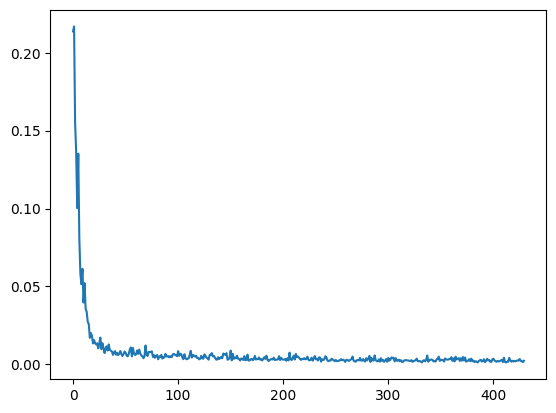

In [175]:
plt.plot(batch_losses)

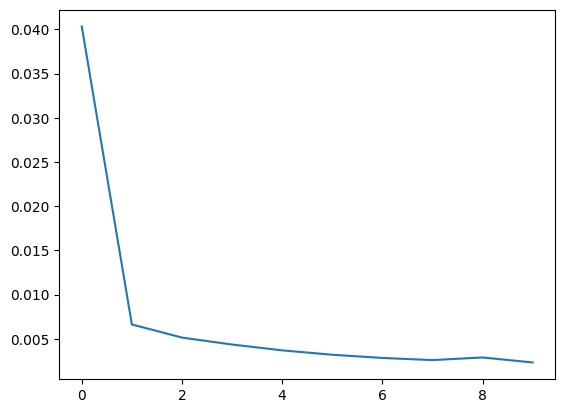

In [176]:
plt.plot(losses)

In [177]:
def compare_orig_and_reconstructed(orig, recon, error, path=None):
    # Revert normalization
    orig = (orig + 1) / 2
    recon = (recon + 1) / 2
    diff = abs(recon - orig)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(np.transpose(orig[0], (1, 2, 0)))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Reconstructed ({error:.4f})")
    plt.imshow(np.transpose(recon[0], (1, 2, 0)))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Difference")
    plt.imshow(np.transpose(diff[0], (1, 2, 0)))
    plt.axis("off")

    if path is not None:
        plt.savefig(path, dpi=199, bbox_inches="tight")
    plt.show()

In [178]:
def compute_reconstruction_error_from_path(img_path):
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
    loss = criterion(output, img_tensor).item()
    return loss, img_tensor.cpu(), output.cpu()

In [179]:
import torch.nn.functional as F

def compute_reconstruction_error(original, reconstructed):
    # Mean squared error per sample
    errors = F.mse_loss(reconstructed, original, reduction='none')
    errors = errors.view(errors.size(0), -1).mean(dim=1)  # (B,)
    return errors

In [180]:
# Run model on validation set
model.eval()
all_errors = []
with torch.no_grad():
    for batch in val_loader:
        imgs = batch.to(DEVICE)
        recon = model(imgs)
        errors = compute_reconstruction_error(imgs, recon)
        all_errors.extend(errors.cpu().numpy())

# Set threshold to 95th percentile of normal reconstruction error
import numpy as np
threshold = np.percentile(all_errors, 95)
threshold

np.float32(0.009129157)

Reconstruction error: 0.0018


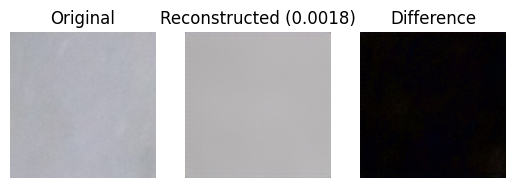

Reconstruction error: 0.1491


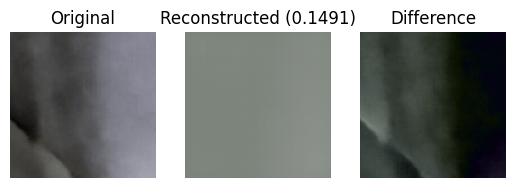

Reconstruction error: 0.0085


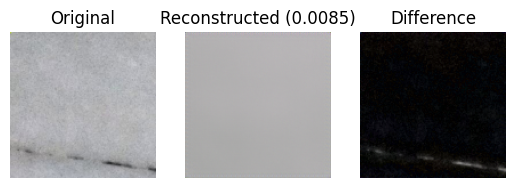

Reconstruction error: 0.0042


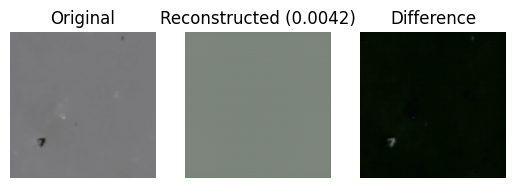

In [181]:
# Example
error, orig, recon = compute_reconstruction_error_from_path("marble/test/good/_0_0_20210525_15434.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_good.png")

error, orig, recon = compute_reconstruction_error_from_path("marble/test/crack/_0_0_20210531_17292_0.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_crack.png")

error, orig, recon = compute_reconstruction_error_from_path("marble/test/joint/_0_4352_20210525_15441_1.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_joint.png")

error, orig, recon = compute_reconstruction_error_from_path("marble/test/dot/_0_2560_20210531_10521_0.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_dot.png")

In [182]:
from numpy import mean


def compute_mean_reconstruction_error(directory, error_thresh = None):
    recon_errors = []
    for file_name in os.listdir(directory):
        error, orig, recon = compute_reconstruction_error_from_path(os.path.join(directory, file_name))
        if error_thresh is not None:
            if error > error_thresh:
                print(error)
                compare_orig_and_reconstructed(orig, recon)
        recon_errors.append(error)
    return mean(recon_errors), min(recon_errors), max(recon_errors)

In [183]:
threshold

np.float32(0.009129157)

In [184]:
print(compute_mean_reconstruction_error("marble/test/good"))
print(compute_mean_reconstruction_error("marble/test/crack"))
print(compute_mean_reconstruction_error("marble/test/joint"))
print(compute_mean_reconstruction_error("marble/test/dot"))

(np.float64(0.002009283042399843), 0.0003183933440595865, 0.02120939828455448)
(np.float64(0.041181357417372055), 0.001021543052047491, 0.33207467198371887)
(np.float64(0.01833337511810119), 0.0006712108734063804, 0.1604766845703125)
(np.float64(0.011069878094813562), 0.0006020698347128928, 0.07066803425550461)


In [185]:
def is_anomaly(original, reconstructed, threshold):
    errors = compute_reconstruction_error(original, reconstructed).cpu().numpy()
    return errors > threshold  # Boolean tensor

In [186]:
results = {
    "good": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "crack": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "joint": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "dot": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
}

for directory, anomaly in [
    ("marble/test/good", False),
    ("marble/test/crack", True),
    ("marble/test/joint", True),
    ("marble/test/dot", True),
]:
    for img_path in os.listdir(directory):
        img = Image.open(os.path.join(directory, img_path))
        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(img_tensor)
        pred = is_anomaly(img_tensor, output, threshold=threshold)
        results[directory.split("/")[-1]]["total"] += 1
        if anomaly:
            if pred:
                results[directory.split("/")[-1]]["tp"] += 1
            else:
                results[directory.split("/")[-1]]["fn"] += 1
        else:
            if pred:
                results[directory.split("/")[-1]]["fp"] += 1
            else:
                results[directory.split("/")[-1]]["tn"] += 1

In [187]:
results

{'good': {'tp': 0, 'tn': 329, 'fp': 11, 'fn': 0, 'total': 340},
 'crack': {'tp': 207, 'tn': 0, 'fp': 0, 'fn': 81, 'total': 288},
 'joint': {'tp': 237, 'tn': 0, 'fp': 0, 'fn': 154, 'total': 391},
 'dot': {'tp': 44, 'tn': 0, 'fp': 0, 'fn': 72, 'total': 116}}

# Precision Recall Curve

In [188]:
all_anomaly_scores = {
    "good": [],
    "crack": [],
    "joint": [],
    "dot": [],
}

for directory, anomaly in [
    ("marble/test/good", False),
    ("marble/test/crack", True),
    ("marble/test/joint", True),
    ("marble/test/dot", True),
]:
    for img_path in os.listdir(directory):
        img = Image.open(os.path.join(directory, img_path))
        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(img_tensor)
        anomaly_score = compute_reconstruction_error(img_tensor, output).cpu().numpy().item()
        all_anomaly_scores[directory.split("/")[-1]].append(anomaly_score)

In [189]:
def calculate_precision_recall(good_scores, anomaly_scores, threshold):
    tp = len([sc for sc in anomaly_scores if sc > threshold])
    fn = len(anomaly_scores) - tp
    tn = len([sc for sc in good_scores if sc < threshold])
    fp = len(good_scores) - tn
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall


In [190]:
def calculate_tpr_fpr(good_scores, anomaly_scores, threshold):
    tp = len([sc for sc in anomaly_scores if sc > threshold])
    fn = len(anomaly_scores) - tp
    tn = len([sc for sc in good_scores if sc < threshold])
    fp = len(good_scores) - tn
    
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

In [191]:
good_scores = all_anomaly_scores["good"]
anomaly_scores = all_anomaly_scores["crack"] + all_anomaly_scores["dot"] + all_anomaly_scores["joint"]

percentile_0 = np.percentile(good_scores, 0)
percentile_100 = np.percentile(good_scores, 100)


threshs_precisions_recalls = []
threshs_tprs_fprs = []
for thresh in np.arange(percentile_0, percentile_100, (percentile_100 - percentile_0) / 100):
    precision, recall = calculate_precision_recall(good_scores, anomaly_scores, thresh)
    tpr, fpr = calculate_tpr_fpr(good_scores, anomaly_scores, thresh)
    threshs_precisions_recalls.append({"thresh": thresh, "Precision": precision, "Recall": recall})
    threshs_tprs_fprs.append({"thresh": thresh, "TPR": tpr, "FPR": fpr})


In [192]:
df_precision_recall_curve = pd.DataFrame(threshs_precisions_recalls)
df_precision_recall_curve.head(2)

,thresh,Precision,Recall
0,0.000318,0.700441,1.0
1,0.000527,0.716862,1.0


In [193]:
fig = px.line(df_precision_recall_curve, x="Recall", y="Precision", width=600, height=600, title="Precision Recall Curve")
fig.update_layout(
    yaxis_range=[0, 1],
    margin=dict(l=20, r=20, t=60, b=20),
    showlegend=False,
    title=dict(font=dict(size=30)),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
)
fig.write_image("../images/precision_recall_curve.pdf")
fig.show()

In [194]:
df_roc_curve = pd.DataFrame(threshs_tprs_fprs)
df_roc_curve.head(2)

,thresh,TPR,FPR
0,0.000318,1.000000,1.0
1,0.000527,0.923529,1.0


In [195]:
from torch import tensor
from torchmetrics.classification import BinaryAUROC, BinaryROC


preds = tensor(good_scores + anomaly_scores)
target = tensor([0] * len(good_scores) + [1] * len(anomaly_scores))
metric = BinaryAUROC(thresholds=None)
auc = metric(preds, target)
auc

tensor(0.9340)

In [196]:
roc = BinaryROC(thresholds=1000)
rocs = roc(preds, target)
fig = px.area(x=rocs[0], y = rocs[1], labels={"x": "False Positive Rate", "y": "True Positive Rate"}, width=600, height=600, title=f"ROC Curve (AUC = {auc:.3f})")
fig.update_layout(
    yaxis_range=[0, 1],
    margin=dict(l=20, r=20, t=60, b=20),
    showlegend=False,
    title=dict(font=dict(size=30)),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.write_image("../images/roc_curve.pdf")
fig.show()

In [197]:
accuracy = results["good"]["tn"] / results["good"]["total"]
accuracy

0.9676470588235294

In [198]:
model.encoder_conv

Sequential(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU(inplace=True)
)

In [199]:
model.decoder_conv

Sequential(
  (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Tanh()
)

In [200]:
torch.save(model.state_dict(), "model.pth")